In [199]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [200]:
train_data = pl.read_csv("train_data.csv")
test_data = pl.read_csv("test_data.csv")
train_data.shape,test_data.shape

((4905, 18), (2105, 18))

In [201]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

# Feature selection

In [202]:
from sklearn.feature_selection import mutual_info_classif

# Compute the mutual information between each feature and the target
mi = mutual_info_classif(train_data.drop("Churn"), train_data["Churn"], discrete_features=True)
mi_series = pd.Series(mi, index=train_data.drop("Churn").columns).sort_values(ascending=False)
print(mi_series)

TotalCharges        0.548010
MonthlyCharges      0.207698
Contract            0.098141
tenure              0.079819
TechSupport         0.062911
OnlineSecurity      0.060971
InternetService     0.054016
OnlineBackup        0.046909
PaymentMethod       0.045041
DeviceProtection    0.043602
StreamingTV         0.031378
StreamingMovies     0.031220
PaperlessBilling    0.019551
Dependents          0.015014
SeniorCitizen       0.012731
Partner             0.010570
MultipleLines       0.001146
dtype: float64


In [203]:
train_data=train_data.drop("Dependents",'SeniorCitizen',"Partner","MultipleLines")
test_data=test_data.drop("Dependents",'SeniorCitizen',"Partner","MultipleLines")
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

No high multicollinear features

In [204]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,14.949773
3,TotalCharges,9.480061
1,tenure,5.748004
2,MonthlyCharges,3.273988


imbalance ratio inverse

In [205]:
len(train_data.filter(train_data["Churn"]==0))/len(train_data.filter(train_data["Churn"]==1))

2.773076923076923

In [206]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ("classifier", LogisticRegression(class_weight={0:1,1:2.77})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('scaler', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1, 1: 2.77}))])

In [207]:
from sklearn.model_selection import cross_validate,StratifiedKFold
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=skf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Standard Deviation of Train roc auc Scores: {cv_results["train_roc_auc"].std()}')
print(f'Mean Train recall Score: {cv_results["train_recall"].mean()}')
print(f'Standard Deviation of Train recall Scores: {cv_results["train_recall"].std()}\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Standard Deviation of Test roc auc Scores: {cv_results["test_roc_auc"].std()}')
print(f'Mean Test recall Score: {cv_results["test_recall"].mean()}')
print(f'Standard Deviation of Test recall Scores: {cv_results["test_recall"].std()}')

Mean Train roc auc Score: 0.8463502224883079
Standard Deviation of Train roc auc Scores: 0.0015995243034946502
Mean Train recall Score: 0.804017094017094
Standard Deviation of Train recall Scores: 0.004619339869015956

Mean Test roc auc Score: 0.8442657208135047
Standard Deviation of Test roc auc Scores: 0.014865916599670594
Mean Test recall Score: 0.7984615384615384
Standard Deviation of Test recall Scores: 0.032960438900967004


In [208]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_predict
predictions= cross_val_predict(pipe,X_test,y_test,cv=skf)
print("logistic regression accuracy :",accuracy_score(y_true=y_test,y_pred=predictions))
print("auc roc",roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

logistic regression accuracy : 0.7429928741092636
auc roc 0.7654928581038137
              precision    recall  f1-score   support

         0.0       0.91      0.72      0.80      1548
         1.0       0.51      0.81      0.63       557

    accuracy                           0.74      2105
   macro avg       0.71      0.77      0.72      2105
weighted avg       0.81      0.74      0.76      2105



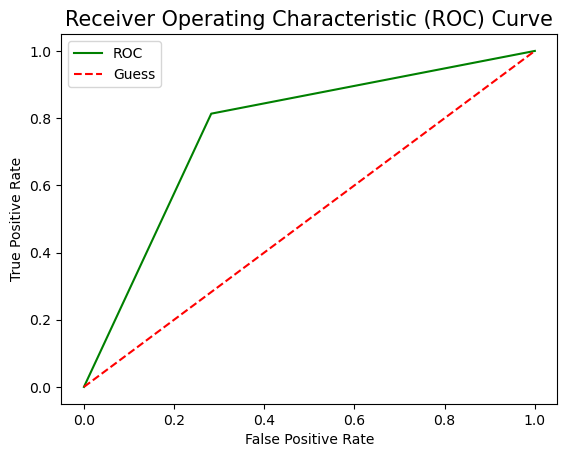

In [209]:
def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positve rate (fpr) and 
    true postive rate (tpr) of a classifier.
    """
    # Plot ROC curve
    plt.plot(fpr, tpr, color='green', label='ROC')
    
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Guess')
    
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
    plt.legend()
    plt.show()
fpr, tpr, thresholds=roc_curve(y_test,predictions)
plot_roc_curve(fpr, tpr)

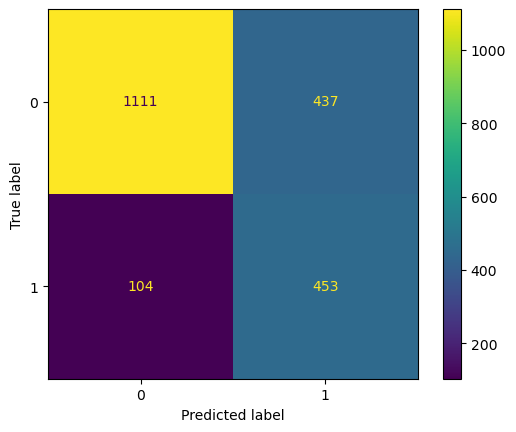

In [210]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predictions))
fig.plot()

In [211]:
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score,recall_score
# Evaluation
roc_auc = roc_auc_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test,predictions)
print(f"ROC AUC: {roc_auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Recall score: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

ROC AUC: 0.77
F1 Score: 0.63
Recall score: 0.81
Accuracy: 0.74


80% of churners are identified 77 AUC